# Assignment M10
Group member: Yifeng Lin; Shichao Zhou

# Introduction

Naïve Bayes classifiers are widely recognized for their efficacy at classifying text data (e.g., sentiment analysis). 
As we’ve learned, many organizations rely on sentiment analysis algorithms to help them gauge the opinions of both existing and potential customers. Today we will construct a Naïve Bayes sentiment classifier for purposes of measuring the sentiment of movie reviews. The data set we will be working with is sourced from this site, comprised of 1000 positive and 1000 negative movie reviews.
http://www.cs.cornell.edu/people/pabo/movie-review-data/.

Step explanation:
+ Data Preparation
 + Remove Punctuations & Stopwords
 + Construct the Term Document Matrix
+ Frequency Distribution Plots
 + Pos Frequency Distribution Plot
 + Neg Frequency Distribution Plot
+ Naïve Bayes Model Training
+ Model Testing
 + Display the 30 Most Informative Features
 + Apply the Model to the Unseen Movie Review
+ Conclusion 

# Data Preparation

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import warnings
import os
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
import gensim
import re

def get_titles(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    all_a = soup.find_all("a", class_="js-navigation-open Link--primary")
    result = []
    for a in all_a:
        result.append(a.get_text())
    return result;

def get_article(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    soup.find("pre")
    return soup.get_text()

def get_reviews_local(path):
    result = []
    files = os.listdir(path)
    for file in files:
        if not os.path.isdir(file):
            f = open(path + "/" + file)
            iter_f = iter(f)
            str = ""
            for line in iter_f:
                str = str + line
            result.append(str)
    return result

In [2]:
# Get files from local. Please save txt_sentoken under " C:/user/.../" before you run the code.
neg_reviews_path = os.getcwd() + "/txt_sentoken/neg"
pos_reviews_path = os.getcwd() + "/txt_sentoken/pos"

neg_reviews = get_reviews_local(neg_reviews_path)
pos_reviews= get_reviews_local(pos_reviews_path)

The below code with # can be run if you need to read the file from github. However, it may take a lot of time to run all the code.

In [3]:
# Load the neg and pos directories to my DAV 6150 Github Repository. 
# neg_article_base_url = "https://raw.githubusercontent.com/sczhou0705/DAV-6150-2/main/txt_sentoken/neg/"
# pos_article_base_url = "https://raw.githubusercontent.com/sczhou0705/DAV-6150-2/main/txt_sentoken/pos/"
# neg_titles = get_titles("https://github.com/sczhou0705/DAV-6150-2/tree/main/txt_sentoken/neg")
# pos_titles =  get_titles("https://github.com/sczhou0705/DAV-6150-2/tree/main/txt_sentoken/pos")

# from os.path import exists
# import csv

# neg_reviews_raw = ""
# pos_reviews_raw = ""

# neg_reviews = []
# pos_reviews= []

# neg_reviews_filename = "neg_articles_all.csv"
# pos_reviews_filename = "pos_articles_all.csv"

# # Load negative reviews from GitHub
# if exists(neg_reviews_filename) == False:
#     for title in neg_titles:
#         neg_reviews_raw += get_article(neg_article_base_url + title)
#     with open(neg_reviews_filename, "a") as f:
#         f.write(neg_reviews_raw)
# with open(neg_reviews_filename, newline='') as f:
#     reader = csv.reader(f)
#     neg_reviews = list(reader)

# print(len(neg_reviews))
# Load positive reviews from Github
# if exists(pos_reviews_filename) == False:
#     for title in pos_titles:
#         pos_reviews_raw += get_article(pos_article_base_url + title)
#     with open(pos_reviews_filename, "a") as f:
#         f.write(pos_reviews_raw)
# with open(pos_reviews_filename, newline='') as f:
#     reader = csv.reader(f)
#     pos_reviews = list(reader)
    
# print(len(pos_reviews))

In [4]:
print("Negative reviews count: " + str(len(neg_reviews)))
print("Positive reviews count: " + str(len(pos_reviews)))

Negative reviews count: 1000
Positive reviews count: 1000


In [5]:
# Label 0 represent negative reviews; Label 1 represent positive review
df_neg_reviews = pd.DataFrame(neg_reviews,columns = ['text'])
df_neg_reviews['label'] = 0
df_pos_reviews = pd.DataFrame(pos_reviews,columns = ['text'])
df_pos_reviews['label'] = 1
df_labeled= pd.concat([df_neg_reviews,df_pos_reviews])
df_labeled

,text,label
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0
...,...,...
995,wow ! what a movie . \nit's everything a movie...,1
996,"richard gere can be a commanding actor , but h...",1
997,"glory--starring matthew broderick , denzel was...",1
998,steven spielberg's second epic film on world w...,1


In [6]:
# Remove punctuations 
p = re.compile(r'[^\w\s]+')
df_labeled['text'] = [p.sub('', x) for x in df_labeled['text'].values.tolist()]
df_labeled

,text,label
0,plot two teen couples go to a church party d...,0
1,the happy bastards quick movie review \ndamn t...,0
2,it is movies like these that make a jaded movi...,0
3,quest for camelot is warner bros first fe...,0
4,synopsis a mentally unstable man undergoing p...,0
...,...,...
995,wow what a movie \nits everything a movie ca...,1
996,richard gere can be a commanding actor but he...,1
997,glorystarring matthew broderick denzel washin...,1
998,steven spielbergs second epic film on world wa...,1


In [7]:
# pip install genism
# The reason to use genism is that the number of stopwords is around 339,more than the package of nltk stopwords.
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.tokenize import word_tokenize
STOPWORDS = STOPWORDS.union(set(['doesnt','dont','isnt','didnt']))
# print(STOPWORDS)
# print('--')
# print(len(STOPWORDS))
# Tokenize the words before removing stopwords.

def clean_text(text):
    word_tokens = word_tokenize(text)
    kw_sentence = [w for w in word_tokens if not w.lower() in STOPWORDS]
    kw_set = set()
    for kw in kw_sentence:
        kw_set.add(kw)
    filtered_sentence = []
    for w in word_tokens:
        if w in kw_set:
            filtered_sentence.append(w)
    result = ""
    for s in filtered_sentence:
        result += ' ' + s
    return result

new_text = []
for t in df_labeled['text']:
    new_text.append(clean_text(t))
df_labeled['text'] = new_text
    

# Print the result after removing stopwords and punctuation.
df_labeled
df_labeled.reset_index(drop=True)

,text,label
0,plot teen couples church party drink drive ac...,0
1,happy bastards quick movie review damn y2k bu...,0
2,movies like jaded movie viewer thankful inven...,0
3,quest camelot warner bros featurelength fully...,0
4,synopsis mentally unstable man undergoing psy...,0
...,...,...
1995,wow movie movie funny dramatic interesting we...,1
1996,richard gere commanding actor hes great films...,1
1997,glorystarring matthew broderick denzel washin...,1
1998,steven spielbergs second epic film world war ...,1


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase = True,stop_words='english',min_df =2)

In [9]:
X = cv.fit_transform(df_labeled['text'])

In [10]:
# Transform the provided data into properly labeled count vectors within a Term-Document matrix

word_freq_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
word_freq_df

,00,000,007,05,10,100,1000,100m,100minute,101,...,zooms,zoot,zorg,zorro,zs,zucker,zuko,zwick,zwicks,zwigoffs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Label the negative value as 0 ; positive value as 1
word_freq_df['Is_pos'] = 0

In [12]:
# positive value as 1
word_freq_df['Is_pos'][1000:] = 1

In [13]:
df_tdm = word_freq_df

In [14]:
df_tdm.head(2)

,00,000,007,05,10,100,1000,100m,100minute,101,...,zoot,zorg,zorro,zs,zucker,zuko,zwick,zwicks,zwigoffs,Is_pos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Frequency Distribution Plots 

In [15]:
X_neg = df_tdm[df_tdm['Is_pos'] == 0].iloc[:,:25551] 

In [16]:
word_list_neg = X_neg.columns
count_list_neg = X_neg.values.sum(axis = 0)
freq_neg = dict(zip(word_list_neg,count_list_neg)) 


<AxesSubplot:>

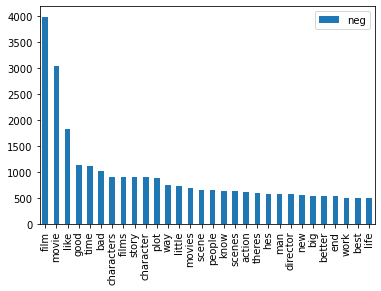

In [17]:
top_words_neg = pd.DataFrame(X_neg.sum()).sort_values(0,ascending=False)
top_words_neg = top_words_neg.rename({0:'neg'},axis='columns')
# Make plots
top_words_neg[:30].plot.bar()


From this bar plot, we can see that in neg movie reviews, 'film,' 'movie,' and 'like' appear more often than others, 'film' appears about 4000 times, 'movies' appears almost 3000 times, 'like' exceeds 1500 times.

In [18]:
X_pos = df_tdm[df_tdm['Is_pos'] == 1].iloc[:,:25551]


In [19]:
word_list_pos = X_pos.columns
count_list_pos = X_pos.values.sum(axis = 0)
freq_pos = dict(zip(word_list_pos,count_list_pos))


<AxesSubplot:>

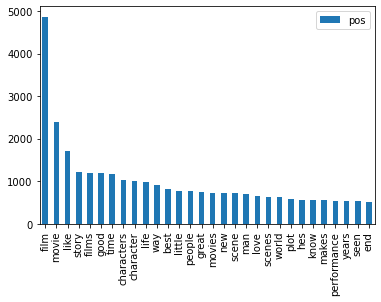

In [20]:
top_words_pos = pd.DataFrame(X_pos.sum()).sort_values(0, ascending=False)
top_words_pos = top_words_pos.rename({0:'pos'},axis='columns')
# Make plots
top_words_pos[:30].plot.bar()

From this bar plot, we can see that in pos movie reviews, 'film,' 'movie,' and 'like' also appear more often than others, 'film' is close to 5000 times, 'movies' exceeds 2000 times, 'like' appears about 1700 times.

We can see from these two graphs that some of the features in the positive graph also appear in the negative plot. The difference is that the frequency of their appearance is not the same. Therefore, they have different sorts in the graph.


# Naïve Bayes Model Training

We know there are Gaussian Naive Bayes,Multinomial Naive Bayes,Complement Naive Bayes,Bernoulli Naive Bayes types of Naïve Bayes classifier.  But for this sample, we will apply Multinomial Naive Bayes to do the model training. The reason is the method best suits discrete values like word counts.

In [21]:
from sklearn.model_selection import train_test_split
# Now split the data into training and testing subsets. 
# We'll set aside 25% of the data for testing purposes; Remember to make sure you specify a value for the inital random_state
# if you want to have the ability to reproduce the exact same training + testing subsets repeatedly
X = df_tdm.iloc[:,:25552]
y = df_tdm['Is_pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500, 25552) (500, 25552) (1500,) (500,)


In [22]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_mnb = MultinomialNB()
naive_bayes_mnb.fit(X_train, y_train)

MultinomialNB()

In [23]:
naive_bayes_mnb.score(X_train, y_train)

0.9826666666666667

In [24]:
# The sum of probabilities == 1
sum([np.exp(1)**x for x in naive_bayes_mnb.feature_log_prob_[0]])

1.000000000000046

In [25]:
# Display and discuss the 30 most informative features 
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
n=30
coefs_with_fns = sorted(zip(naive_bayes_mnb.feature_log_prob_[0], X_train.columns))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


	-12.3640	10year         		-4.3332	film           
	-12.3640	12hour         		-4.6605	movie          
	-12.3640	12th           		-5.1348	like           
	-12.3640	14th           		-5.6012	good           
	-12.3640	14year         		-5.6317	time           
	-12.3640	150th          		-5.7059	bad            
	-12.3640	155            		-5.8316	films          
	-12.3640	160            		-5.8612	story          
	-12.3640	16th           		-5.8612	characters     
	-12.3640	175            		-5.8778	character      
	-12.3640	1773           		-5.8809	plot           
	-12.3640	17day          		-6.0113	way            
	-12.3640	1839           		-6.0468	little         
	-12.3640	1888           		-6.1159	scene          
	-12.3640	18wheeler      		-6.1434	movies         
	-12.3640	1912           		-6.1635	people         
	-12.3640	1919           		-6.1655	scenes         
	-12.3640	1932           		-6.1943	theres         
	-12.3640	1933           		-6.1964	know           
	-12.3640	1935           		-6.2

We can discover the 30 most informative features determined by our Naïve Bayes classifier from top to bottom from the above-right part. The highest informative features are 'film,' 'movie,' 'like,' 'good,' 'time,' and so on.

# Model Testing
- Apply the above MultinomialNB model to test the subset and evaluate whether the model perform well.
- Apply the model to the new movie review (Bayes Naive Theorem) and identify the model performance on the new movie review.

In [26]:
# Predict the test set
predictions = naive_bayes_mnb.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print('F1_score: ',f1_score(y_test, predictions))
print('Roc_auc_score: ',roc_auc_score(y_test, predictions))

Accuracy score:  0.83
Precision score:  0.8192771084337349
Recall score:  0.8360655737704918
F1_score:  0.8275862068965517
Roc_auc_score:  0.8301421618852459


The accuracy rate is 83%. High precision relates to the low false-positive rate. We have a 0.819 precision and 0.839 recall suitable for this model as it’s above 0.5. Also, the roc score is over 0.8, so we can interpret this model to perform well.

In [27]:
from nltk.tokenize import word_tokenize

In [28]:
new_sentence = """There were some things I didn't like about this film. Here's what I remember most 
strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the 
"bear" from Hercules in New York); an extra with a less than believable laugh; an ex-drug
addict martian with tics; child actors who recite their lines very slowly and carefully; 
a newspaper headline declaring that Santa has been "kidnapped", and a giant robot. The 
least appealing acting job in the film must be when Mother Claus and her elves have been 
"frozen" by the "Martians'" weapons. They seemed to display an exaggerated amount of 
fear. Perhaps this was the preferred acting style in the 1960's??"""
print(type(new_sentence))

<class 'str'>


In [29]:
# Remove punctuation
new_sentence = new_sentence.translate(str.maketrans('', '', string.punctuation))

In [30]:
# Remove stopwords
new_word_list = word_tokenize(new_sentence)
filtered_sentence = [w for w in new_word_list if not w.lower() in STOPWORDS]
filtered_sentence = []
 
for w in new_word_list:
    if w not in STOPWORDS:
        filtered_sentence.append(w)
new_word_list = filtered_sentence


Now, the new sentence is a clean sentence. Then, we need to find out if the new movie review is a positive review or negative review. We will use Bayes Naive Theorem to solve this. We need to find out what is the probability of class"positive" given the new movie sentence and the probability of class'negative" given the new sentence. We will look at individual words,not the whole sentence. In the above step, we've already split the sentence to words and assume that every word in a sentence is independent of the other ones. 

We reference some code and calculation logic from "https://medium.com/analytics-vidhya/naive-bayes-classifier-for-text-classification-556fabaf252b". Suppose a word from the new movie does not appear in the class within the dataset,the equation becomes zero. Therefore, it is impossible for us to need all the words of the new movies. For avoiding the problem of zero probabilities,we will use Laplace smoothing(alhpa = 1).  α is a smoothing Laplace parameter to discard the influence of words absent in the vocabulary.

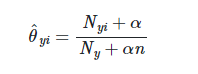

In [31]:
# Total_cnts_features_neg : Sum up the number of times features appeared in samples from class negative
total_cnts_features_neg = count_list_neg.sum(axis=0)
# Total count of all features appeared in sample dataset.
total_features = len(df_tdm.columns)-1 # 25551 features
prob_neg_with_ls = []
for word in new_word_list:
# We've already calculated each word frequency appeared in negative class in the session of "Frequency Distribution Plots".
    if word in freq_neg.keys():
        count = freq_neg[word]
    else:
        count = 0
# Laplace smoothing(alhpa = 1).We multiply by 1000 here because the original number is too small
    prob_neg_with_ls.append((count + 1)/(total_cnts_features_neg + total_features) * 1000) 
neg_dict = dict(zip(new_word_list,prob_neg_with_ls))
neg_dict

{'There': 0.003272947452828645,
 'things': 1.318997823489944,
 'I': 0.003272947452828645,
 'like': 6.009131523393392,
 'film': 13.075425074050436,
 'Heres': 0.003272947452828645,
 'remember': 0.3109300080187213,
 'strongly': 0.029456527075457803,
 'man': 1.862307100659499,
 'ingeniously': 0.003272947452828645,
 'fakelooking': 0.009818842358485933,
 'polar': 0.016364737264143225,
 'bear': 0.09818842358485934,
 'costume': 0.10473431849051663,
 'funnier': 0.0654589490565729,
 'Hercules': 0.003272947452828645,
 'New': 0.003272947452828645,
 'York': 0.003272947452828645,
 'extra': 0.08509663377354476,
 'believable': 0.17346621499991818,
 'laugh': 0.4156643265092379,
 'exdrug': 0.003272947452828645,
 'addict': 0.04254831688677238,
 'martian': 0.07855073886788747,
 'tics': 0.003272947452828645,
 'child': 0.304384113113064,
 'actors': 1.217536452452256,
 'recite': 0.019637684716971866,
 'lines': 0.6120411736789565,
 'slowly': 0.14400968792446037,
 'carefully': 0.04582126433960103,
 'newspaper'

In [32]:
# Total_cnts_features_pos : Sum up the number of times features appeared in samples from class positive
total_cnts_features_pos = count_list_pos.sum(axis=0)
total_features = len(df_tdm.columns)-1 # 25551 features
prob_pos_with_ls = []
for word in new_word_list:
    if word in freq_pos.keys():
        count = freq_pos[word]
    else:
        count = 0
    # We multiply by 1000 here because the original number is too small
    prob_pos_with_ls.append((count + 1)/(total_cnts_features_pos + total_features) * 1000)
pos_dict = dict(zip(new_word_list,prob_pos_with_ls))
pos_dict

{'There': 0.0029380914745399684,
 'things': 1.3162649805939057,
 'I': 0.0029380914745399684,
 'like': 5.050579244734205,
 'film': 14.293815023636947,
 'Heres': 0.0029380914745399684,
 'remember': 0.3143757877757766,
 'strongly': 0.07639037833803917,
 'man': 2.053725940703438,
 'ingeniously': 0.008814274423619905,
 'fakelooking': 0.005876182949079937,
 'polar': 0.014690457372699842,
 'bear': 0.08226656128711911,
 'costume': 0.07051419538895924,
 'funnier': 0.047009463592639494,
 'Hercules': 0.0029380914745399684,
 'New': 0.0029380914745399684,
 'York': 0.0029380914745399684,
 'extra': 0.10577129308343886,
 'believable': 0.2321092264886575,
 'laugh': 0.29087105597945684,
 'exdrug': 0.0029380914745399684,
 'addict': 0.014690457372699842,
 'martian': 0.008814274423619905,
 'tics': 0.014690457372699842,
 'child': 0.4201470808592155,
 'actors': 1.016579650190829,
 'recite': 0.011752365898159874,
 'lines': 0.3995804405374357,
 'slowly': 0.2497377753358973,
 'carefully': 0.08226656128711911,
 

In [33]:
# Multiple all the prob_pos values.
result_pos = 1
for key in pos_dict:
# P(new_movie_review_sentence|pos_reviews) 
    result_pos = result_pos * pos_dict[key]
# P(new_movie_review_sentence|pos_reviews)*P(positive)
    result_pos = result_pos * 0.5
result_pos

5.23201592407163e-95

In [34]:
# Multiple all the prob_neg values.
result_neg = 1
for key in neg_dict:
# P(new_movie_review_sentence|neg_reviews) 
    result_neg = result_neg * neg_dict[key]
# P(new_movie_review_sentence|neg_reviews)*P(negative)    
    result_neg = result_neg * 0.5
result_neg

1.3134229254185563e-93

In [35]:
result_neg > result_pos

True

Therefore, the new movie review can be classfied as 'negative' review as well as we expected.

From this new movie review, we can see from the first sentence that this film review is biased to a negative review.  We use the model to test the paragraph, and the result also shows negative. So we think the classification is accurate, performing as expected.



# Conclusion

We use the MultinomialNB model to perform sentiment analysis on data sets related to movies reviews. The model we designed performs well, with scores (accuracy, F1_score, precision, recall, and roc) exceeding 80%. In addition, we used the model to test a new movie review, and the result was a negative review, which is consistent with our intuitive judgment. Once again proves the feasibility of our model. However, we believe that there are still areas for improvement in the future. For example, when performing data cleaning and excluding stopwords and punctuation,  we also need to consider the singular and plural words.

# Reference
- https://medium.com/analytics-vidhya/naive-bayes-classifier-for-text-classification-556fabaf252b
- https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- https://towardsdatascience.com/comparing-a-variety-of-naive-bayes-classification-algorithms-fc5fa298379e